In [137]:
import xarray as xr
import matplotlib.dates as mdates
import numpy as np
import matplotlib
from matplotlib import rcParams
import datetime
import pandas as pd
import cftime
import pylab as plt
import netCDF4 as nc
from numpy import ma
import dask as dd
from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm
from eofs.standard import Eof
import xeofs as xf

## Map Plotting imports

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

#stash codes
stash_ch4 = 'mass_fraction_of_methane_in_air'
stash_co = 'mass_fraction_of_carbon_monoxide_in_air'
stash_ch4_oh = 'm01s50i041'
stash_oh = 'mass_fraction_of_hydroxyl_radical_in_air'
stash_o3 = 'mass_fraction_of_ozone_in_air'
stash_trop = 'm01s50i062'
stash_mass = 'm01s50i063'
stash_temp = 'surface_temperature'
stash_nox = 'm01s50i081'

#define functions
def molec_cm3(conc_kg_kg, mass, vol, mr):
    molec_box = conc_kg_kg*mass/mr*1000*n_a #molecules per box
    cm3 = molec_box/(vol*1e6) #molec per cm3
    return cm3

def moving_average(x, months):
    return np.convolve(x, np.ones(months), 'valid') / months

def full_average(x, months):
    return np.convolve(x, np.ones(months), 'same') / months

#define constants
n_a = 6.02e23
oh_mr = 17

In [138]:
# Area and volume datasets

area = nc.Dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')
box_area = area.variables['areacella'][:]

total_area = np.sum(box_area)
area_scaled = box_area/total_area
lat_area_scaled = area_scaled[:,0]#1D array of latitude scaling values

In [139]:
# Altitude data to obtain volumes

data_alt = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/vol_n96.nc')
vol = data_alt.grid_cell_volume
vol = vol.data

In [140]:
des_pcs = xr.open_dataarray(f'../../OH_ENSO/pc_949.nc')

In [141]:
## Plot temperature in NINO3.4

temp_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_temp_apm_1960_2340_PI.nc')
temp_949 = temp_data_949.surface_temperature
lat = temp_data_949.latitude
lon = temp_data_949.longitude
time_949 = temp_data_949.time

# apply nino3.4 mask to data
nino34_temp = temp_949.loc[:,-5:5,190:240]
nino_mean_949 = np.mean(nino34_temp,axis=(1,2))

# More complex way to make mask, which does preserve array size
# temp_data_949['mask'] = xr.ones_like(temp_949)
# temp_data_949['mask'] = temp_data_949.mask.where(np.abs(temp_949.latitude)<5,other=0.) 
# temp_data_949['mask'] = temp_data_949.mask.where(temp_949.longitude<240,other=0.)
# temp_data_949['mask'] = temp_data_949.mask.where(temp_949.longitude>190,other=0.)
# enso_949 = ma.masked_where(temp_data_949.mask!=1,temp_949)

## calculate rolling mean for enso data
# note doing it this way does cause some error at the edges, but does make the datasets the same length, which is convienient

# bl949_3monmean = moving_average(nino_mean_949,3)
bl949_3monmean = nino_mean_949.rolling(time=3,min_periods=1,center=True).mean()

# da.rolling(time=3, center=True).mean().dropna("time")

# bl949_30yrmean = moving_average(nino_mean_949,360)
bl949_30yrmean = nino_mean_949.rolling(time=360,min_periods=1,center=True).mean()

temp_anomaly_bl949 = bl949_3monmean - bl949_30yrmean

dtime_949 = nc.date2num(time_949,'days since 2000-01-01 00:00:00',calendar='360_day',has_year_zero=True)

In [152]:
# Smooth PC data and temperature anomaly to try and reduce noise
from scipy.signal import savgol_filter
smooth_temp = savgol_filter(temp_anomaly_bl949,33,5)

# Resample PC to have monthly frequency
pcs_monthly = des_pcs[:,0].resample(time='1M').interpolate('linear')

# Smoothing PC data with last entry removed as is a NaN
smooth_pcs = savgol_filter(pcs_monthly[:-1],39,4)

# Create variable to make comparisons easier as times are equivalent
smooth_temp_compare = smooth_temp[29:-6]

In [153]:
from scipy.stats import pearsonr
pearsonr(smooth_temp_compare[:],smooth_pcs[:])

(0.6431306614567568, 0.0)

Smoothing data has resulted in higher correlation values being achieved, suggesting noise might have been some of the problem

## Plot unsmoothed data to show areas of disagreement appear to be at small ENSO index values

Text(0.5, 1.0, 'u-bl949: unsmoothed PC 1 and NINO3.4 SST anomalies')

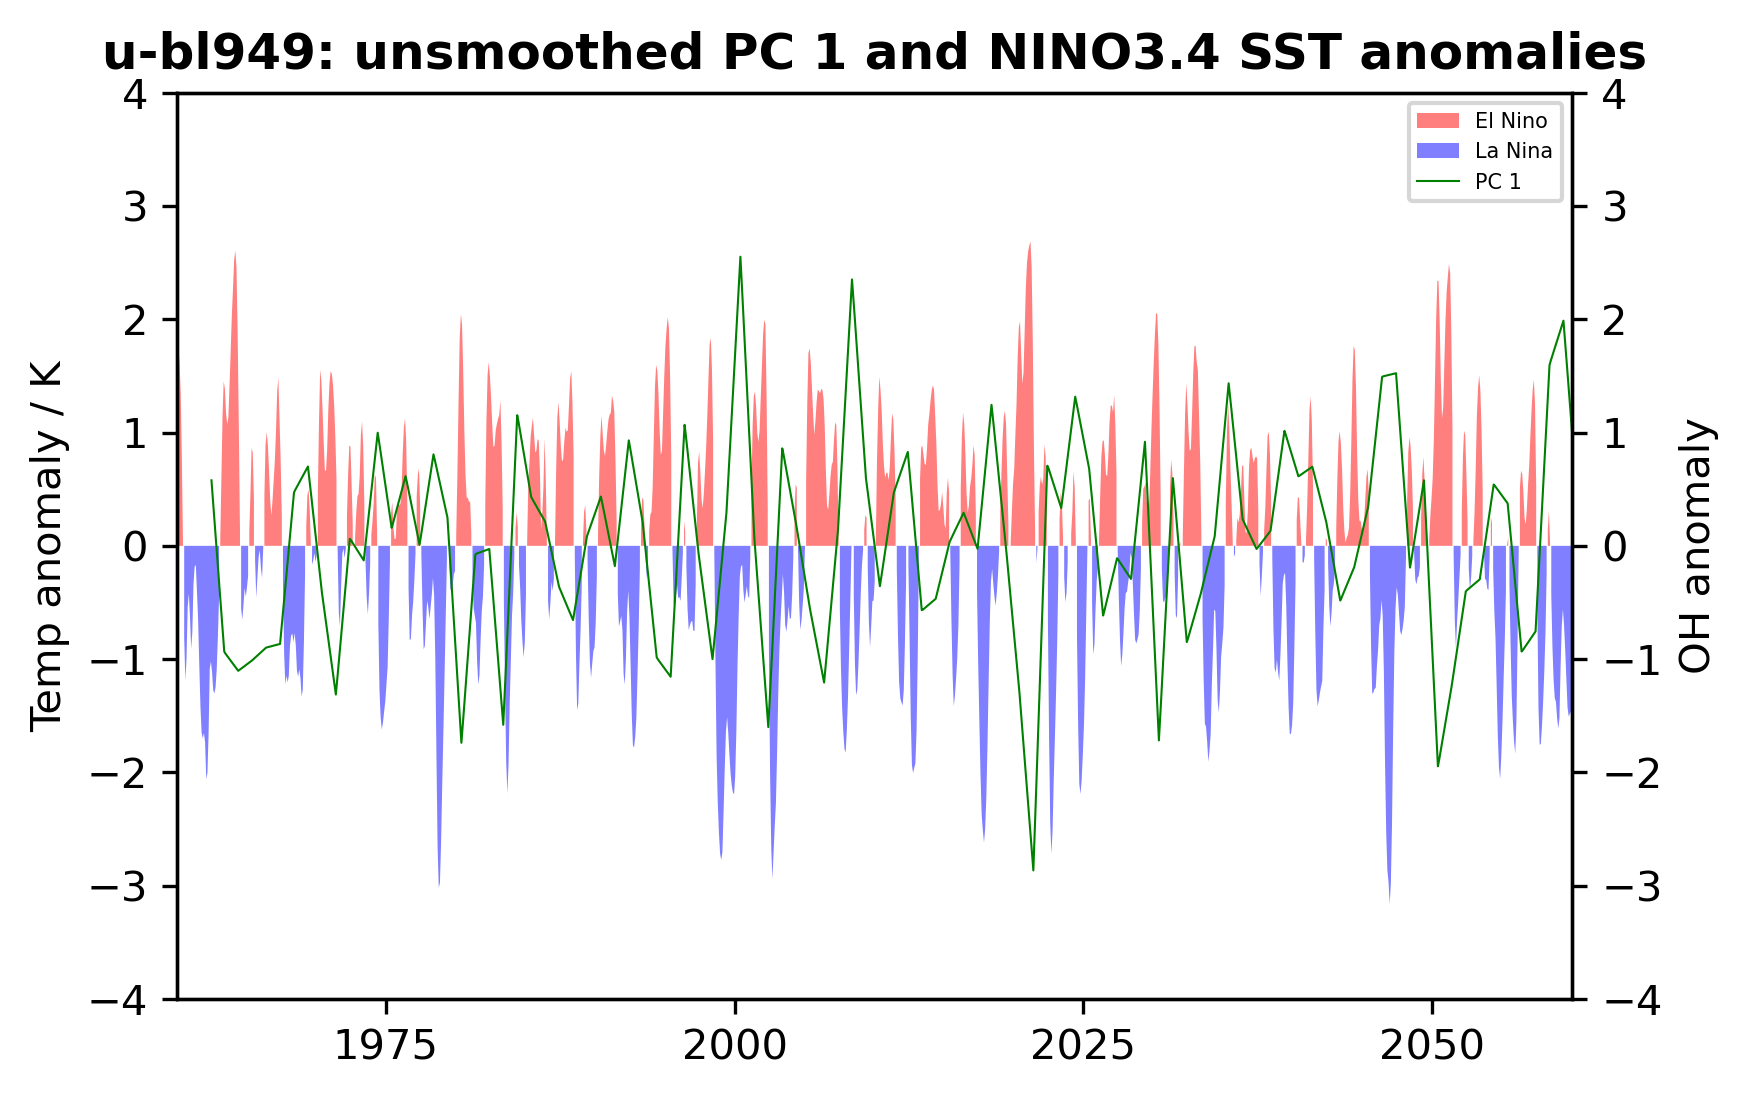

In [150]:
# Plot the nino temperature anomaly

fig = plt.figure(dpi=300)
ax = plt.axes()

ax.set_ylabel('SST anomaly / K')
# p4, = ax.plot(temp_anomaly_bl949[29:-6].time, smooth[29:-6], label = 'SST anomaly', c = 'k', linewidth = 0.4)
p1 = ax.fill_between(dtime_949, temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 > 0), facecolor='red', alpha=0.5, label = 'El Nino')
p2 = ax.fill_between(dtime_949, temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 < 0), facecolor='blue', alpha=0.5, label = 'La Nina')

ax1 = ax.twinx()
ax1.set_ylabel('OH anomaly', fontsize=10)
p3, = ax1.plot(pcs_monthly[:-1].time,-pcs_monthly[:-1], c='green', linewidth = 0.5,label='PC 1')

ax.set_ylim(-4,4)
ax1.set_ylim(-4,4)
ax.set_xlim(dtime_949[0],dtime_949[1200])

ax.set_ylabel('Temp anomaly / K')
ax.legend(handles=[p1,p2,p3],fontsize=5,loc ='upper right')
plt.xlabel('Time')

plt.title('u-bl949: unsmoothed PC 1 and NINO3.4 SST anomalies',fontweight='bold')

## Check the smoothed data comparison between the PC and the temperature anomaly, use scatter plot to check for overall correlations

In [165]:
# Selecting only the temperature points which have a yearly data equivalent
temp_anomaly_pcmonth = temp_anomaly_bl949.where(temp_anomaly_bl949['time.month']==6,drop=True)

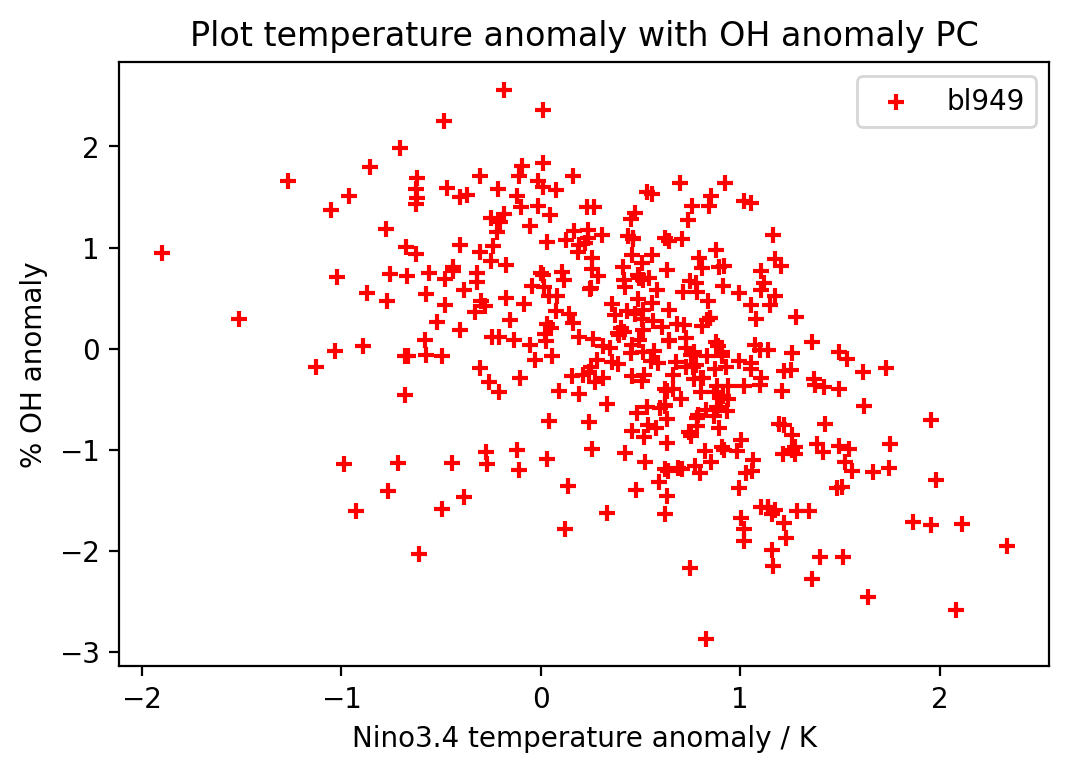

In [175]:
# Plot ratio with gradient to look for correlations
fig = plt.figure(dpi=200)
ax = plt.axes()
plt.title('Plot temperature anomaly with OH anomaly PC')

ax.scatter(temp_anomaly_pcmonth[2:],-des_pcs[:,0],label='bl949',c='r',marker='+')

ax.set_xlabel('Nino3.4 temperature anomaly / K')
ax.set_ylabel('% OH anomaly')

plt.legend()

Text(0.5, 1.0, 'u-bl949: smoothed PC 1 and NINO3.4 SST anomalies')

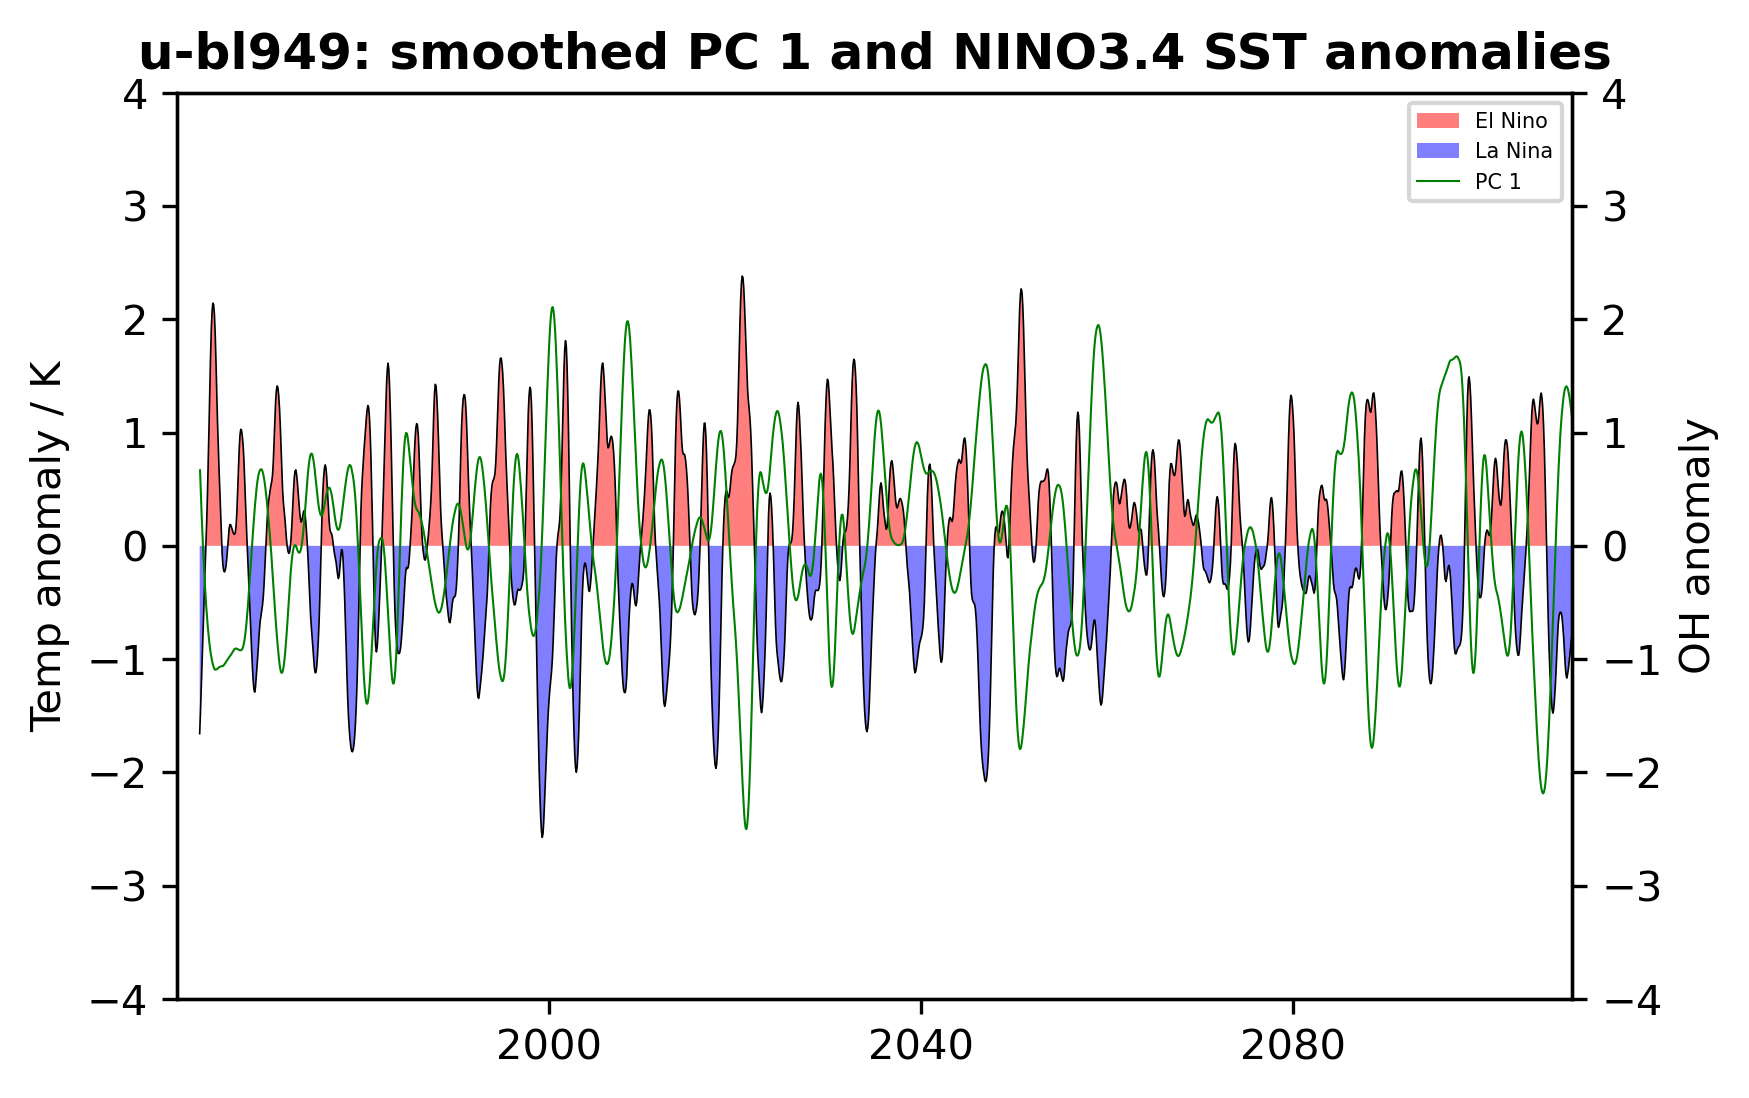

In [145]:
# Plot the smoothed data

fig = plt.figure(dpi=300)
ax = plt.axes()

ax.set_ylabel('SST anomaly / K')
p4, = ax.plot(temp_anomaly_bl949[29:-6].time, smooth[29:-6], label = 'SST anomaly', c = 'k', linewidth = 0.4)
# p1 = ax.fill_between(dtime_949, temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 > 0), facecolor='red', alpha=0.5, label = 'El Nino')
# p2 = ax.fill_between(dtime_949, temp_anomaly_bl949, 0 ,where=(temp_anomaly_bl949 < 0), facecolor='blue', alpha=0.5, label = 'La Nina')

p1 = ax.fill_between(dtime_949[29:-6], smooth[29:-6], 0 ,where=(smooth[29:-6] > 0), facecolor='red', alpha=0.5, label = 'El Nino')
p2 = ax.fill_between(dtime_949[29:-6], smooth[29:-6], 0 ,where=(smooth[29:-6] < 0), facecolor='blue', alpha=0.5, label = 'La Nina')

ax1 = ax.twinx()
ax1.set_ylabel('OH anomaly', fontsize=10)
# p3, = ax1.plot(pcs_monthly[:-1].time,pcs_monthly[:-1], c='green', linewidth = 0.5,label='PC 1')
ax1.plot(pcs_monthly[:-1].time,-smooth_pcs, c='green', linewidth = 0.5,label='PC 1')

ax.set_ylim(-4,4)
ax1.set_ylim(-4,4)
ax.set_xlim(dtime_949[0],dtime_949[1800])

ax.set_ylabel('Temp anomaly / K')
ax.legend(handles=[p1,p2,p3],fontsize=5,loc ='upper right')
plt.xlabel('Time')

plt.title('u-bl949: smoothed PC 1 and NINO3.4 SST anomalies',fontweight='bold')